In [1]:
import numpy as np
import pulser
from pprint import pprint
import matplotlib.pyplot as plt

from scipy.linalg import expm

from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser.waveforms import RampWaveform
from pulser.devices import Chadoq2

from IPython.display import HTML
import matplotlib.animation

/Users/Brian/workspace/Research/CO2_Capture_GNN/.conda/lib/python3.10/site-packages/qutip/__init__.py:65: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


In [1]:
import time
import numpy as np
np.random.seed(42)
a = np.random.uniform(size=(300, 300))
runtimes = 10

timecosts = []
for _ in range(runtimes):
    s_time = time.time()
    for i in range(100):
        a += 1
        np.linalg.svd(a)
    timecosts.append(time.time() - s_time)

print(f'mean of {runtimes} runs: {np.mean(timecosts):.5f}s')

In [ ]:
def Kron(*arr):
    K = arr[0]
    for i in range(1,len(arr)):
        K = np.kron(K,arr[i])
    return K

I = np.eye(2)
Z = np.array([[1,0],[0,-1]])
X = np.array([[0,1],[1,0]])

n = 6

if(n==2):
    Xi = np.concatenate(([Kron(X,I)],[Kron(I,X)]))
    Zi = np.concatenate(([Kron(Z,I)],[Kron(I,Z)]))
    Ni = (np.eye(2**n)+Zi)/2
else:
    Xi = np.concatenate(([Kron(X,*[I]*(n-1))],[Kron(*([I]*i+[X]+[I]*(n-i-1))) for i in range(1,n-1)],[Kron(*[I]*(n-1),X)]))
    Zi = np.concatenate(([Kron(Z,*[I]*(n-1))],[Kron(*([I]*i+[Z]+[I]*(n-i-1))) for i in range(1,n-1)],[Kron(*[I]*(n-1),Z)]))
    Ni = (np.eye(2**n)+Zi)/2



Omega = 1   * 2*np.pi
delta = 0.7 * 2*np.pi
U = 138e5

def BaseHamiltonian(Omega,delta):
    H = Omega/2*np.sum(Xi, axis=0) - delta*np.sum(Ni, axis=0)
    return H

v = Kron(*[np.array([0,1])]*n)

def Obs(v): # ,A
    # return (np.sum( [v.transpose().conj()@Ni[i]@v for i in A] )).real/len(A)
    return np.sum([ (v.transpose().conj()@Ni[i]@v).real for i in [0]])



In [ ]:
0.7 * 2*np.pi

4.39822971502571

129.98694572404085


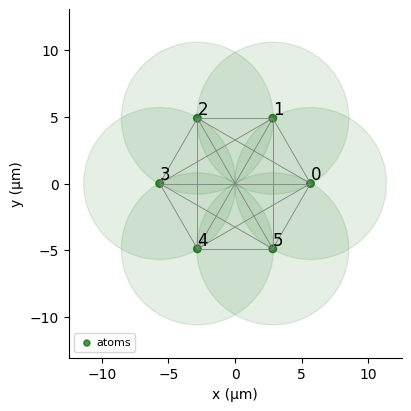

In [ ]:
print((U/Omega)**(1/3))
w = np.exp(1j*2*np.pi/(n))

def graph_desc(rNN):
    #G1 = [[rNN/(2*np.sin(np.pi/(3)))*(1+w**i).real,rNN/(2*np.sin(np.pi/(3)))*(w**i).imag] for i in range(3)] \
    #    + [[rNN/(2*np.sin(np.pi/(3)))*(-1.+w**1).real,rNN/(2*np.sin(np.pi/(3)))*(.5j+w**1).imag]] \
    #    + [[rNN/(2*np.sin(np.pi/(3)))*(-.8+w**2).real,rNN/(2*np.sin(np.pi/(3)))*(-.5j+w**2).imag]] \
    #    + [[rNN/(2*np.sin(np.pi/(3)))*(-3+w**2).real,rNN/(2*np.sin(np.pi/(3)))*(-.3j+w**2).imag]]
    
    #G1 = [[rNN/(2*np.sin(np.pi/(3)))*(1+w**i).real,rNN/(2*np.sin(np.pi/(3)))*(w**i).imag] for i in range(3)]
    #G1+= [[rNN/(2*np.sin(np.pi/(3)))*(-1+w**2).real,rNN/(2*np.sin(np.pi/(3)))*(w**2).imag],\
    #    [rNN/(2*np.sin(np.pi/(3)))*(-2.5+w**2).real,rNN/(2*np.sin(np.pi/(3)))*(w**2).imag] ]
    #G1 = [[rNN*i, 0] for i in range(n)]
    G1 = [[rNN/(2*np.sin(np.pi/(4)))*(w**i).real,rNN/(2*np.sin(np.pi/(4)))*(w**i).imag] for i in range(n)]
    return G1

#rNN = 11
#G1 = [[rNN/(2*np.sin(np.pi/(n)))*(w**i).real,rNN/(2*np.sin(np.pi/(n)))*(w**i).imag] for i in range(n)]
G1 = graph_desc(8)

Rij1 = np.zeros((n,n))
for i in range(n):
    for j in range(i):
        Rij1[i,j] = np.linalg.norm(np.array(G1[i])-np.array(G1[j]))
        Rij1[j,i] = Rij1[i,j]
        
#print(Rij1)
H = BaseHamiltonian(Omega,delta)
H1 = H.copy()
for i in range(n):
    for j in range(i):
        H1 += U/Rij1[i,j]**6 * (Ni[i]@Ni[j])# + Ni[j]@Ni[i])/2

qubits1 = dict(enumerate(G1))
reg1 = Register(qubits1)
reg1.draw(blockade_radius=(U/Omega)**(1/6), draw_half_radius=True, draw_graph=True)

In [ ]:
G1

[[5.656854249492381, 0.0],
 [2.8284271247461907, 4.898979485566357],
 [-2.828427124746189, 4.8989794855663575],
 [-5.656854249492381, 2.198129442157285e-15],
 [-2.8284271247461934, -4.898979485566356],
 [2.828427124746187, -4.898979485566359]]

In [ ]:
print(Rij1)

[[ 0.          5.65685425  9.79795897 11.3137085   9.79795897  5.65685425]
 [ 5.65685425  0.          5.65685425  9.79795897 11.3137085   9.79795897]
 [ 9.79795897  5.65685425  0.          5.65685425  9.79795897 11.3137085 ]
 [11.3137085   9.79795897  5.65685425  0.          5.65685425  9.79795897]
 [ 9.79795897 11.3137085   9.79795897  5.65685425  0.          5.65685425]
 [ 5.65685425  9.79795897 11.3137085   9.79795897  5.65685425  0.        ]]


In [ ]:
(U/Omega)**(1/6)

11.401181768748398

In [ ]:
M = 100
T = np.linspace(0.05,2.5,M)

O1_B = np.zeros((M))
O1_C = np.zeros((M))
O2_B = np.zeros((M))
O2_C = np.zeros((M))
for i,t in enumerate(T):
    vt = expm(-1j*t*H1)@v
    O1_B[i] = Obs(vt)#,B
    O1_C[i] = Obs(vt)#,C

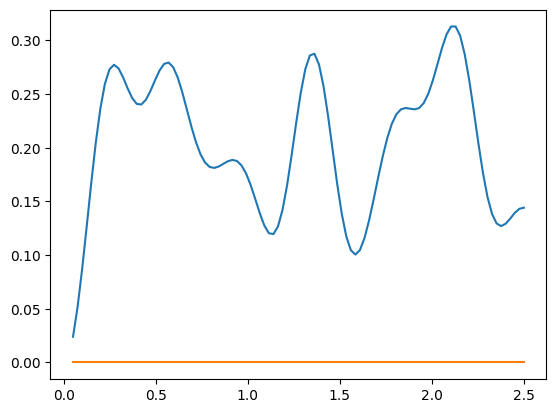

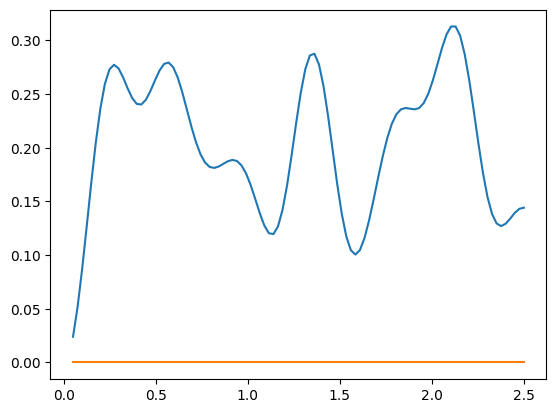

In [ ]:

plt.plot(T,O1_B)
plt.plot(T,O2_B)
# plt.ylim([0,0.5])
plt.show()

plt.plot(T,O1_C)
plt.plot(T,O2_C)
plt.show()

In [ ]:
#list(zip(pulse_param,rNN_vec))

In [ ]:
K = 100
rNN_vec = np.linspace(25,.5,K)
pulse_param = np.linspace(U/0.5**6,U/25**6,K)
omega_param = U/rNN_vec[:]**6
#omega_param = [Omega for _ in range(K)]
#delta_param = -U/rNN_vec[:]**6 
delta_param = [delta for _ in range(K)]
pulse_params = list(zip(omega_param, delta_param))
#print(pulse_params)
M = 200
T = np.linspace(0,15,M)

O = np.zeros((K,M))

#w = np.exp(1j*2*np.pi/(n+1))

#G1 = graph_desc(11)
#Rij1 = np.zeros((n,n))
#for i in range(n):
#    for j in range(i):
#        Rij1[i,j] = np.linalg.norm(np.array(G1[i])-np.array(G1[j]))
#        Rij1[j,i] = Rij1[i,j]

def interactionHamiltonian(U,R):
    H1=np.zeros((2**n,2**n))
    for i in range(n):
        for j in range(i):
            H1 += U/R[i,j]**6 * (Ni[i]@Ni[j])
    return H1

for k in range(K):
    if(k%10==0):
        print(k)
    rNN = rNN_vec[k]
    #G1 = [[rNN/(2*np.sin(np.pi/(n)))*(w**i).real,rNN/(2*np.sin(np.pi/(n)))*(w**i).imag] for i in range(n)]
    G1 = graph_desc(rNN_vec[k])
    #G1 = [[rNN/(2*np.sin(np.pi/(3)))*(1+w**i).real,rNN/(2*np.sin(np.pi/(3)))*(w**i).imag] for i in range(3)] \
    #        + [[rNN/(2*np.sin(np.pi/(3)))*(-1.+w**1).real,rNN/(2*np.sin(np.pi/(3)))*(.5j+w**1).imag]] \
    #        + [[rNN/(2*np.sin(np.pi/(3)))*(-.8+w**2).real,rNN/(2*np.sin(np.pi/(3)))*(-.5j+w**2).imag]] \
    #        + [[rNN/(2*np.sin(np.pi/(3)))*(-3+w**2).real,rNN/(2*np.sin(np.pi/(3)))*(-.3j+w**2).imag]]
    
    Rij1 = np.zeros((n,n))
    for i in range(n):
        for j in range(i):
            Rij1[i,j] = np.linalg.norm(np.array(G1[i])-np.array(G1[j]))
            Rij1[j,i] = Rij1[i,j]

    
    #Omega, delta = pulse_params[k]
    H1 = BaseHamiltonian(Omega,delta)
    
    #H1 = H.copy()
    H1+= interactionHamiltonian(U,Rij1)
    
    #print(H1)
    #break
    for i,t in enumerate(T):
        vt = expm(-1j*t*H1)@v
        O[k,i] = Obs(vt)#,0)

0


KeyboardInterrupt: 

In [ ]:
print(Omega, delta)

6.283185307179586 4.39822971502571


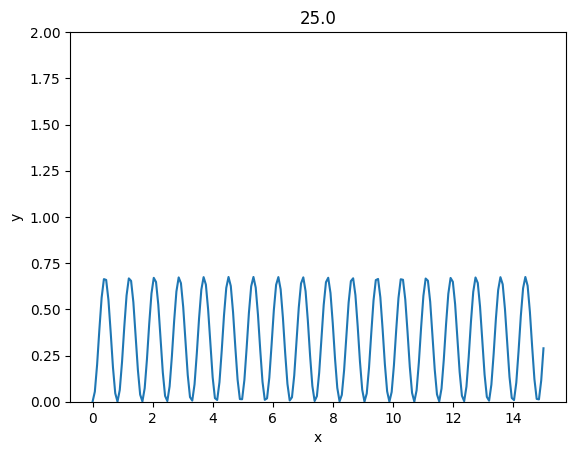

In [ ]:
fig, ax = plt.subplots()
l, = plt.plot(T,O[0,:])
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.set_ylim([0,2])

def animate(i):
    l.set_data(T,O[i,:])
    ax.set_title(rNN_vec[i])
ani = matplotlib.animation.FuncAnimation(fig, animate, interval=25, frames=K)

       
HTML(ani.to_jshtml())

In [ ]:
#from scipy import signal



#fig, ax = plt.subplots()


##f, t, Zxx = signal.stft(O[0,:], 1000, nperseg=1000)

##cax = ax.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=1, shading='gouraud')
##fig.colorbar(cax)

##l, = plt.plot(T,O[0,:])
#ax.set_ylabel('y')
#ax.set_xlabel('x')
#ax.set_ylim([0,1])

#def animate(i):
#    l.set_data(T,O[i,:])
#    ax.set_title(rNN_vec[i])
#    #f, t, Zxx = signal.stft(O[i,:], 1000, nperseg=1000)
#    #cax.set_array(np.abs(Zxx).flatten())


#ani = matplotlib.animation.FuncAnimation(fig, animate, interval=25, frames=K)

       
#HTML(ani.to_jshtml())



##plt.title('STFT Magnitude')
##plt.ylabel('Frequency [Hz]')
##plt.xlabel('Time [sec]')
##plt.show()

In [ ]:
import scipy

In [ ]:
FFT = np.zeros((K,M//2))
FFTw = np.zeros((K,M//2))
dt = T[1]-T[0]
xf = scipy.fft.fftfreq(M, dt)[:M//2]

from scipy.signal.windows import blackman
window = blackman(T.shape[-1])

for i in range(K):
    FFT[i,:] = 2/M*np.abs(scipy.fft.fft(O[i,:])[:M//2])
    FFTw[i,:] = 2/M*np.abs(scipy.fft.fft(O[i,:]*window)[:M//2])
    


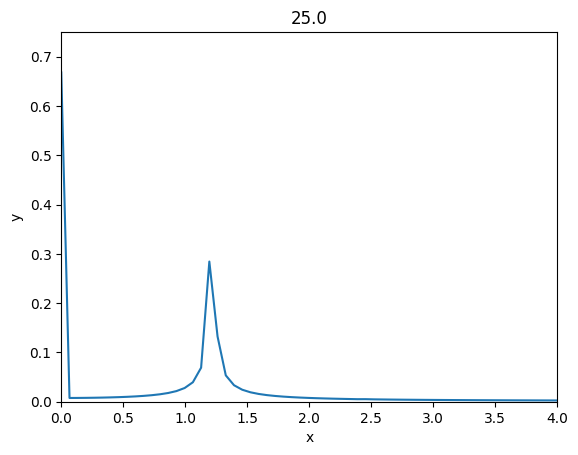

In [ ]:
fig, ax = plt.subplots()
l, = plt.plot(xf,FFTw[0,:])
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.set_ylim([0,0.75])
ax.set_xlim([0,4])

def animate(i):
    l.set_data(xf,FFT[i,:])
    ax.set_title(rNN_vec[i])
ani = matplotlib.animation.FuncAnimation(fig, animate, interval=100, frames=K)

       
HTML(ani.to_jshtml())

# ani.save('FFT_rNN_hexa.gif')

In [ ]:
print(Omega/2/np.pi*np.sqrt(n))
print(Omega/2/np.pi*np.sqrt(6))

2.0
2.449489742783178


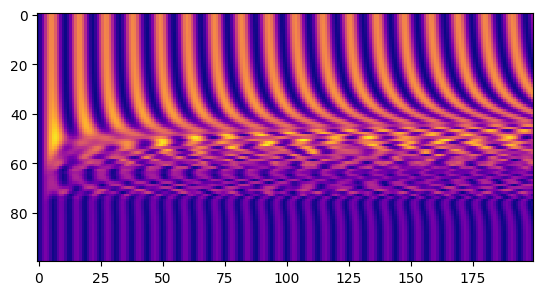

In [ ]:

plt.imshow(O, cmap='plasma', interpolation='nearest')
plt.show()

In [ ]:
print(G1)

#print()
G = graph_desc(1)
#print(G)

[[0.3535533905932738, 0.0], [2.1648901405887335e-17, 0.3535533905932738], [-0.3535533905932738, 4.329780281177467e-17], [-6.4946704217662e-17, -0.3535533905932738]]


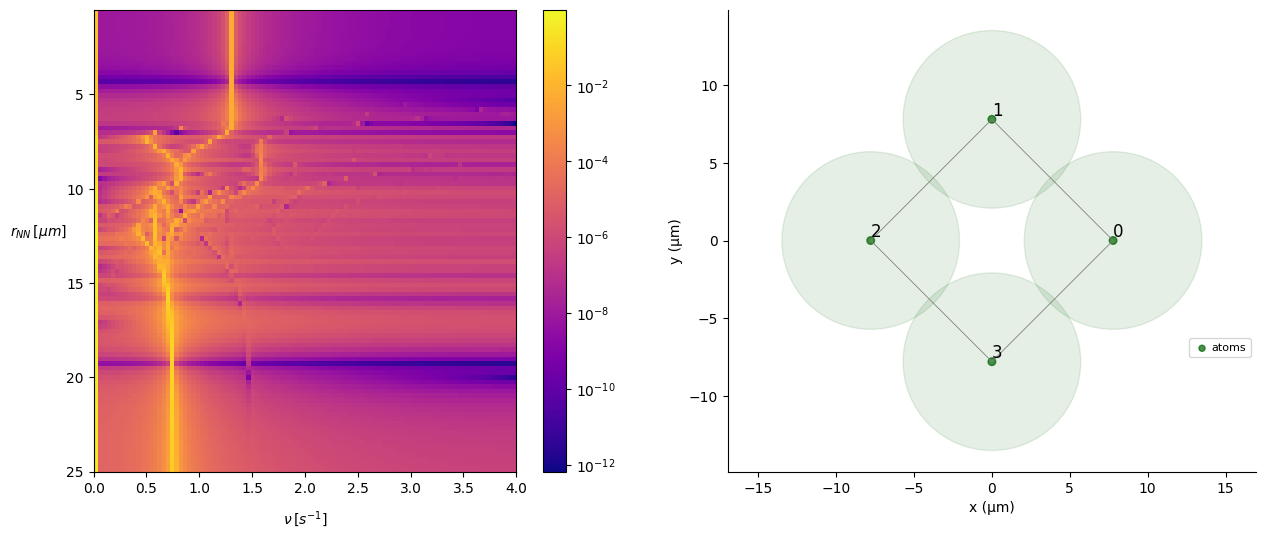

In [ ]:
#fftbis = np.array([FFT[i,:],rNN_vec[i] for i in range(100)])
#print(fftbis.shape)
#fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,6))
plt.rcParams['text.usetex'] = False
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,6))
ax1.set_ylabel(r'$r_{NN}\, [\mu m]$',rotation=0,labelpad=20)#, loc='top')
ax1.set_xlabel(r'$\nu\,[s^{-1}]$',rotation=0,labelpad=10)#, loc='right')
im = ax1.imshow(np.log(FFT),cmap='plasma',origin='lower', interpolation='nearest', extent=(0,4,25,0.5), aspect='auto')
#ax2.imshow(np.log(FFTw),cmap='plasma',origin='lower', interpolation='nearest', extent=(0,4,25,0.5))
#ax1.setgrid()
ax1.set_title("")

import matplotlib.ticker as ticker
def fmt(x, pos):
    #a, b = '{:.2e}'.format(x).split('e')
    #b = int(b)
    return r'$10^{{{}}}$'.format(int(x))

plt.colorbar(im, format=ticker.FuncFormatter(fmt))
#fig.colorbar(im)
#ax1.grid(alpha=0.5, linestyle='-', linewidth=1)
G1 = graph_desc(11)

qubits1 = dict(enumerate(G1))
reg1 = Register(qubits1)
reg1.draw(blockade_radius=(U/Omega)**(1/6), draw_half_radius=True, draw_graph=True,custom_ax=ax2)


plt.show()

In [ ]:
print(Omega/2/np.pi*np.sqrt(n))

2.0


In [ ]:
rNN_vec[75]

6.439393939393938

In [ ]:
G = graph_desc(11)
print(G)
#qubits1 = dict(enumerate(G))
#reg1 = Register(qubits1)
#reg1.draw(blockade_radius=(U/Omega)**(1/6), draw_half_radius=True, draw_graph=True)

[[7.778174593052023, 0.0], [4.762758309295214e-16, 7.778174593052023], [-7.778174593052023, 9.525516618590428e-16], [-1.428827492788564e-15, -7.778174593052023]]
